In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
from datetime import datetime
import os
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
import backtrader as bt

os.chdir("..")
import config
os.chdir("notebooks")

%matplotlib inline

# 1. Data Processing

In [2]:
def get_data(tickers, start, end):
    df = yf.download(tickers, start=start, end=end)['Close']
    log_returns = np.log(df / df.shift(1))
    log_returns.dropna(inplace=True)
    return df, log_returns

In [3]:
def fit_garch_multi(returns):
    volatilities = pd.DataFrame(index=returns.index, columns=returns.columns)
    models = {}
    for ticker in returns.columns:
        model = arch_model(returns[ticker] * 100, vol='Garch', p=2, q=2)
        res = model.fit(disp='off')
        models[ticker] = res
        volatilities[ticker] = res.conditional_volatility / 100
    return models, volatilities

In [4]:
TICKERS = config.TICKERS + ['^GSPC']
START = datetime(2015, 1, 1)
END = datetime.today()

In [5]:
prices, returns = get_data(TICKERS, START, END)
prices, returns

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  16 of 16 completed


(Ticker            AAPL        AVGO        BND       GOOGL         IYW  \
 Date                                                                    
 2015-01-02   24.261042    7.587782  61.378384   26.319653   24.157244   
 2015-01-05   23.577574    7.466487  61.556587   25.818159   23.771879   
 2015-01-06   23.579792    7.296675  61.734821   25.180983   23.449190   
 2015-01-07   23.910439    7.493779  61.771984   25.106926   23.646517   
 2015-01-08   24.829132    7.868277  61.675400   25.194401   24.236174   
 ...                ...         ...        ...         ...         ...   
 2025-08-11  227.179993  303.899994  73.470001  201.000000  182.899994   
 2025-08-12  229.649994  312.829987  73.480003  203.339996  185.509995   
 2025-08-13  233.330002  309.089996  73.750000  201.960007  185.330002   
 2025-08-14  232.779999  311.230011  73.540001  202.940002  184.899994   
 2025-08-15  231.014999         NaN  73.434196  204.960007  183.843994   
 
 Ticker             LLY        META 

In [6]:
_, volatilities = fit_garch_multi(returns)
volatilities

Ticker,AAPL,AVGO,BND,GOOGL,IYW,LLY,META,MGC,MGK,MSFT,NVDA,QQQ,SPY,TLT,VOO,^GSPC
Date,,,,,,,,,,,,,,,,
2015-01-05,0.019925,0.022584,0.002467,0.015627,0.012516,0.010979,0.017421,0.010139,0.010199,0.020879,0.022343,0.011160,0.010294,0.011298,0.010241,0.010353
2015-01-06,0.021370,0.022160,0.002513,0.016307,0.013123,0.011074,0.017728,0.011893,0.011430,0.019653,0.022383,0.011871,0.012523,0.011681,0.012370,0.012600
2015-01-07,0.019595,0.022703,0.002571,0.017485,0.013617,0.010930,0.019336,0.011931,0.011906,0.019126,0.024992,0.012506,0.011950,0.012184,0.011842,0.011815
2015-01-08,0.019128,0.022891,0.002410,0.015610,0.012978,0.011060,0.018073,0.011454,0.011587,0.018109,0.026068,0.012380,0.011932,0.011504,0.011863,0.011740
2015-01-09,0.021958,0.026706,0.002382,0.016248,0.014554,0.012086,0.017367,0.012590,0.012671,0.019904,0.024928,0.013309,0.012978,0.011772,0.012897,0.012895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-08,0.021415,0.020772,0.003072,0.013971,0.011769,0.042522,0.036100,0.008801,0.011800,0.015528,0.023810,0.010716,0.008440,0.007578,0.008360,0.008188
2025-08-11,0.024435,0.020418,0.002913,0.017843,0.011486,0.032341,0.024939,0.008743,0.011262,0.014944,0.022857,0.010391,0.008343,0.007469,0.008276,0.008184
2025-08-12,0.022318,0.019669,0.002819,0.013922,0.011182,0.037219,0.025497,0.008280,0.010723,0.013849,0.022513,0.010010,0.007726,0.007235,0.007664,0.007620


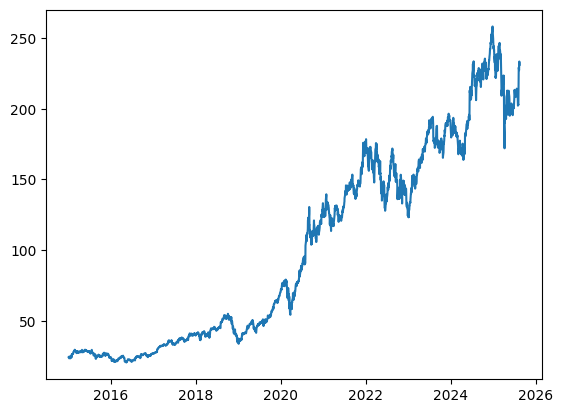

In [7]:
plt.plot(prices["AAPL"])

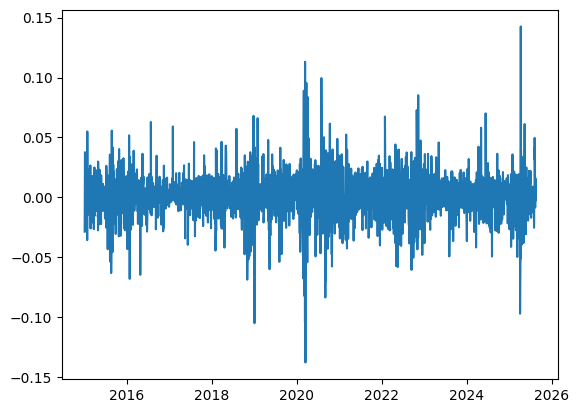

In [8]:
plt.plot(returns["AAPL"])

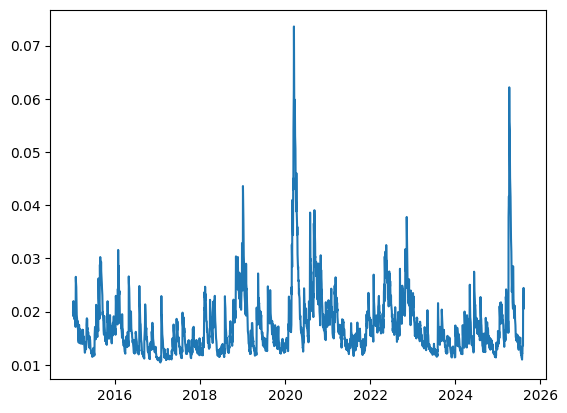

In [9]:
plt.plot(volatilities["AAPL"])

# 2. Environment Construction

In [10]:
class PortfolioEnv(gym.Env):
    def __init__(self, log_returns, volatilities, risk_free_rate=0.02):
        super(PortfolioEnv, self).__init__()
        self.log_returns = log_returns.values
        self.volatilities = volatilities.values
        self.n_assets = log_returns.shape[1]
        self.n_steps = len(log_returns)
        self.risk_free_rate = risk_free_rate / 252
        self.portfolio_init_value = 10_000.0

        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets * 2,), dtype=np.float32)
        self.reset()

    def reset(self, *, seed=None, options=None):
        self.current_step = 0
        self.portfolio_value = self.portfolio_init_value
        self.weights = np.random.random(self.n_assets)
        return self._get_obs(), {}

    def _get_obs(self):
        current_returns = self.log_returns[self.current_step]
        current_vols = self.volatilities[self.current_step]
        return np.concatenate([current_returns, current_vols]).astype(np.float32)

    def step(self, action):
        self.current_step += 1  # use next day's returns

        action = np.clip(action, 0, None)
        self.weights = action / np.sum(action) if np.sum(action) > 0 else np.ones(self.n_assets) / self.n_assets

        port_return = np.dot(self.weights, np.exp(self.log_returns[self.current_step]) - 1)
        port_vol = np.sqrt(np.dot(self.weights**2, self.volatilities[self.current_step]**2))

        # Reward: daily sharpe ratio
        reward = (port_return - self.risk_free_rate) / port_vol if port_vol > 0 else 0

        self.portfolio_value *= (1 + port_return)

        done = self.current_step >= self.n_steps - 1
        truncated = False
        info = { "PortValue": self.portfolio_value, "PortReturn": (100 * (self.portfolio_value - self.portfolio_init_value) / self.portfolio_init_value), "PortWeights": self.weights }

        return self._get_obs(), reward, done, truncated, info

In [11]:
log_returns = pd.read_csv(os.path.join("..", "data", "train_returns.csv"))
vol = pd.read_csv(os.path.join("..", "data", "train_vols.csv"))

In [12]:
log_returns

,AAPL,AVGO,BND,GOOGL,IYW,LLY,META,MGC,MGK,MSFT,NVDA,QQQ,SPY,TLT,VOO
0,-0.028577,-0.016115,0.002900,-0.019238,-0.016081,-0.009897,-0.016191,-0.017690,-0.016667,-0.009239,-0.017035,-0.014777,-0.018225,0.015586,-0.017725
1,0.000094,-0.023007,0.002891,-0.024989,-0.013667,0.005033,-0.013565,-0.009036,-0.010211,-0.014786,-0.030788,-0.013499,-0.009464,0.017857,-0.009882
2,0.013925,0.026655,0.000601,-0.002945,0.008379,-0.007053,0.000000,0.011790,0.012842,0.012626,-0.002609,0.012809,0.012384,-0.001976,0.012417
3,0.037703,0.048766,-0.001564,0.003478,0.024630,0.023413,0.026309,0.017215,0.017239,0.028994,0.036927,0.018959,0.017590,-0.013332,0.017416
4,0.001072,0.010638,0.001684,-0.012287,-0.003838,-0.013352,-0.005644,-0.007997,-0.008148,-0.008441,0.004020,-0.006604,-0.008046,0.010894,-0.008457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2265,-0.012781,-0.009082,-0.004512,-0.018380,-0.006870,-0.005194,0.007664,-0.003959,-0.005907,-0.007203,0.008978,-0.005160,-0.003226,-0.015311,-0.003162
2266,-0.004021,0.000257,-0.003020,-0.004851,0.001021,0.006569,0.013819,0.001742,0.000636,-0.000516,0.022639,0.001185,0.001369,-0.009612,0.001280
2267,0.023887,0.024077,0.004389,0.022655,0.026180,0.012020,0.018886,0.014771,0.020726,0.018696,0.062299,0.020457,0.014175,0.009818,0.014202
2268,-0.002266,0.007083,-0.000137,0.015083,0.003142,-0.000879,-0.003435,-0.001006,0.002566,0.002931,0.016833,0.001974,-0.001518,-0.006396,-0.002433


# 3. Model Setup and Training

In [13]:
env = make_vec_env(lambda: PortfolioEnv(log_returns, vol), n_envs=1)

In [14]:
# model = PPO("MlpPolicy", env, verbose=1)
# model.learn(total_timesteps=100_000)
model = PPO.load(os.path.join("..", "models", "PPO_100K_Model"))

In [15]:
test_returns = pd.read_csv(os.path.join("..", "data", "test_returns.csv"))
test_vols = pd.read_csv(os.path.join("..", "data", "test_vols.csv"))

In [16]:
test_returns.shape, test_vols.shape

((399, 15), (399, 15))

In [17]:
test_returns

,AAPL,AVGO,BND,GOOGL,IYW,LLY,META,MGC,MGK,MSFT,NVDA,QQQ,SPY,TLT,VOO
0,-0.003228,0.017803,0.005197,-0.001407,0.004406,0.008737,-0.002162,0.000647,0.002147,0.004848,0.008647,0.002079,-0.000441,0.005599,-0.000343
1,0.001777,0.006976,0.002044,0.004004,0.002602,0.011262,0.012954,0.001292,0.001378,0.009934,-0.002045,0.000513,0.000693,-0.001966,0.000457
2,-0.012394,0.006551,-0.007104,-0.001122,0.001785,-0.013073,-0.018951,-0.003528,-0.000689,0.004623,0.030104,-0.000098,-0.003678,-0.017770,-0.003408
3,-0.005187,-0.010178,-0.002334,-0.007184,-0.005365,-0.008959,0.002473,-0.004664,-0.005219,-0.002052,-0.005852,-0.005657,-0.005574,-0.001583,-0.005583
4,0.032051,0.035811,-0.001375,0.014108,0.019051,-0.008880,0.020847,0.009131,0.014514,0.011234,0.018629,0.014094,0.008854,-0.009339,0.008853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,0.041485,0.003975,-0.002177,0.024628,0.009890,-0.024020,0.009758,0.009406,0.009337,0.002301,0.010620,0.009285,0.007767,-0.004344,0.007626
395,-0.008372,-0.003515,0.000681,-0.002087,-0.005561,0.015180,-0.004469,-0.001848,-0.001819,-0.000517,-0.003509,-0.002963,-0.001979,0.001145,-0.002051
396,0.010814,0.028961,0.000136,0.011575,0.014169,0.006606,0.031021,0.010187,0.010091,0.014215,0.006024,0.012490,0.010590,-0.005048,0.010619
397,0.015897,-0.012027,0.003668,-0.006810,-0.000971,0.032405,-0.012636,0.001319,0.000129,-0.016498,-0.008609,0.000500,0.003417,0.008247,0.003481


In [18]:
cum = returns.tail(399).cumsum()
(np.exp(cum["^GSPC"].iloc[-1]) - 1) * 100

np.float64(35.22749845710295)

# 4. Model Testing + Evaluation

In [19]:
env = make_vec_env(lambda: PortfolioEnv(test_returns, test_vols), n_envs=1)

In [20]:
episodes = 10
total_returns = 0
for episode in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0

    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        score += reward
    total_returns += round(info[0]["PortReturn"], 2)
    print("Episode: {} | Portfolio Value: ${:,} | Portfolio Return: {}%".format(episode, round(info[0]["PortValue"], 2), round(info[0]["PortReturn"], 2)))
print("Average Portfolio Return: {}%".format(round(total_returns / episodes, 2)))

Episode: 1 | Portfolio Value: $16,356.65 | Portfolio Return: 63.57%
Episode: 2 | Portfolio Value: $17,715.97 | Portfolio Return: 77.16%
Episode: 3 | Portfolio Value: $18,316.54 | Portfolio Return: 83.17%
Episode: 4 | Portfolio Value: $17,063.64 | Portfolio Return: 70.64%
Episode: 5 | Portfolio Value: $14,998.47 | Portfolio Return: 49.98%
Episode: 6 | Portfolio Value: $13,261.96 | Portfolio Return: 32.62%
Episode: 7 | Portfolio Value: $15,856.34 | Portfolio Return: 58.56%
Episode: 8 | Portfolio Value: $17,001.87 | Portfolio Return: 70.02%
Episode: 9 | Portfolio Value: $13,428.14 | Portfolio Return: 34.28%
Episode: 10 | Portfolio Value: $15,570.0 | Portfolio Return: 55.7%
Average Portfolio Return: 59.57%


# 5. Backtesting

In [21]:
class MultiVolFeed(bt.feeds.PandasData):
    lines = ('vol',)
    params = (('vol', -1),)

In [22]:
class RLPortfolioStrategy(bt.Strategy):
    def __init__(self, model, tickers):
        self.model = model
        self.tickers = tickers
        self.n_assets = len(tickers)
        self.obs = None
    
    def notify_order(self, order):
        if order.status in [order.Completed]:
            if order.isbuy():
                print(f"BUY EXECUTED: {order.data._name}, Price={order.executed.price}, Size={order.executed.size}")
            else:
                print(f"SELL EXECUTED: {order.data._name}, Price={order.executed.price}, Size={order.executed.size}")
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print(f"Order problem: {order.data._name}, Status={order.Status[order.status]}")


    def next(self):
        current_prices = np.array([self.datas[i].close[0] for i in range(self.n_assets)])
        current_vols = np.array([self.datas[i].vol[0] for i in range(self.n_assets)])
        current_returns = np.log(current_prices / np.array([self.datas[i].close[-1] for i in range(self.n_assets)]))
        obs = np.concatenate([current_returns, current_vols])
        action, _ = self.model.predict(obs, deterministic=True)
        weights = action / np.sum(action) if np.sum(action) > 0 else np.ones(self.n_assets) / self.n_assets

        value = self.broker.getvalue()
        buy_orders = []
        sell_orders = []
        for i, ticker in enumerate(self.tickers):
            target_value = value * weights[i]
            current_position = self.getpositionbyname(ticker).size * current_prices[i]
            if target_value > current_position:
                qty = int((target_value - current_position) / current_prices[i])
                if qty > 0:
                    buy_orders.append((self.getdatabyname(ticker), qty))
            elif target_value < current_position:
                qty = (current_position - target_value) / current_prices[i]
                if qty > 0:
                    sell_orders.append((self.getdatabyname(ticker), qty))
        for order in sell_orders:
            self.sell(data=order[0], size=order[1])
        for order in buy_orders:
            self.buy(data=order[0], size=order[1])


In [24]:
tickers = config.TICKERS
start = '2023-01-01'
end = '2025-01-01'

In [25]:
# S&P500 return over same time frame as following code
sp = returns['^GSPC'][-655:-154]
(np.exp(sp.cumsum().iloc[-1]) - 1) * 100

np.float64(53.80268630411598)

In [26]:
prices, returns = get_data(tickers, start, end)
_, vols = fit_garch_multi(returns)
vols

[*********************100%***********************]  15 of 15 completed


Ticker,AAPL,AVGO,BND,GOOGL,IYW,LLY,META,MGC,MGK,MSFT,NVDA,QQQ,SPY,TLT,VOO
Date,,,,,,,,,,,,,,,
2023-01-04,0.015064,0.020205,0.005089,0.020313,0.016448,0.016951,0.033753,0.010318,0.014094,0.021488,0.034396,0.014392,0.010323,0.012064,0.010243
2023-01-05,0.014965,0.020447,0.005089,0.018944,0.016282,0.016294,0.033548,0.010128,0.013906,0.021488,0.034271,0.014191,0.010097,0.012062,0.010022
2023-01-06,0.014909,0.020367,0.005079,0.019497,0.015824,0.017353,0.033345,0.009667,0.013391,0.021299,0.031486,0.013591,0.009634,0.011606,0.009548
2023-01-09,0.015340,0.029303,0.005079,0.017716,0.016037,0.016770,0.033145,0.009801,0.013586,0.021299,0.034575,0.013656,0.009713,0.011931,0.009587
2023-01-10,0.014862,0.030751,0.005068,0.017461,0.016276,0.021393,0.032948,0.010840,0.014020,0.021113,0.032934,0.014485,0.011026,0.011662,0.010869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.012573,0.049540,0.003093,0.017740,0.013288,0.020548,0.020819,0.010070,0.011817,0.012435,0.028728,0.012699,0.010139,0.009825,0.009953
2024-12-26,0.012716,0.044712,0.003091,0.017293,0.013135,0.017162,0.020819,0.009652,0.011618,0.012435,0.029853,0.012379,0.009583,0.009655,0.009489
2024-12-27,0.012558,0.039155,0.003087,0.017093,0.012985,0.018428,0.020819,0.009616,0.011598,0.012434,0.026827,0.012277,0.009454,0.009363,0.009307


In [27]:
data_df = prices.copy()
for i, ticker in enumerate(tickers):
    data_df[f'vol{i}'] = vols[ticker]
data_df

Ticker,AAPL,AVGO,BND,GOOGL,IYW,LLY,META,MGC,MGK,MSFT,...,vol5,vol6,vol7,vol8,vol9,vol10,vol11,vol12,vol13,vol14
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,123.330635,53.111015,65.984787,88.588707,73.278137,357.730377,124.059402,127.631752,168.849487,234.808945,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-04,124.602699,53.759686,66.359390,87.554901,73.506065,355.877991,126.675064,128.474060,169.649506,224.537674,...,0.033753,0.034396,0.020205,0.016951,0.014094,0.010318,0.010243,0.010323,0.014392,0.016448
2023-01-05,123.281342,53.258789,66.286301,85.686104,71.880966,351.781158,126.247398,126.954056,166.627090,217.882858,...,0.033548,0.034271,0.020447,0.016294,0.013906,0.010128,0.010022,0.010097,0.014191,0.016282
2023-01-06,127.817368,56.464760,67.017227,86.819313,73.793427,355.721161,129.310593,129.742325,170.726135,220.450714,...,0.033345,0.031486,0.020367,0.017353,0.013391,0.009667,0.009548,0.009634,0.013591,0.015824
2023-01-09,128.339981,55.357399,67.199974,87.495247,74.794266,342.871887,128.763611,129.655182,172.099030,222.597076,...,0.033145,0.034575,0.029303,0.016770,0.013586,0.009801,0.009587,0.009713,0.013656,0.016037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,257.286682,238.395798,70.249168,195.647552,165.188446,792.676208,606.742920,217.546906,356.114868,437.647369,...,0.020819,0.028728,0.049540,0.020548,0.011817,0.010070,0.009953,0.010139,0.012699,0.013288
2024-12-26,258.103729,244.045380,70.298065,195.138748,165.248383,791.151978,602.350220,217.487228,355.436310,436.432068,...,0.020819,0.029853,0.044712,0.017162,0.011618,0.009652,0.009489,0.009583,0.012379,0.013135
2024-12-27,254.685883,240.454727,70.151390,192.305435,162.790955,780.223267,598.816040,215.100098,349.997833,428.881104,...,0.020819,0.026827,0.039155,0.018428,0.011598,0.009616,0.009307,0.009454,0.012277,0.012985


In [35]:
cerebro = bt.Cerebro()
for i, ticker in enumerate(tickers):
    single_df = pd.DataFrame({
        'open': prices[ticker],
        'close': prices[ticker],
        'vol': data_df[f'vol{i}'],
    }).dropna()
    data = MultiVolFeed(dataname=single_df)
    cerebro.adddata(data, name=ticker)

In [ ]:
cerebro.addstrategy(RLPortfolioStrategy, model=model, tickers=tickers)
cerebro.broker.setcash(10_000.0)
cerebro.broker.setcommission(commission=1e-3)
cerebro.run()
print("Final Portfolio Value: ${:,.2f}".format(cerebro.broker.getvalue()))

BUY EXECUTED: NVDA, Price=14.252330780029297, Size=2
BUY EXECUTED: LLY, Price=351.7811584472656, Size=7
BUY EXECUTED: MGK, Price=166.62709045410156, Size=14
BUY EXECUTED: MGC, Price=126.95405578613281, Size=10
BUY EXECUTED: VOO, Price=336.4776306152344, Size=7
BUY EXECUTED: SPY, Price=366.7764587402344, Size=1
BUY EXECUTED: QQQ, Price=257.57659912109375, Size=1
SELL EXECUTED: LLY, Price=355.7211608886719, Size=-7.0
SELL EXECUTED: MGK, Price=170.72613525390625, Size=-10.601940298384452
SELL EXECUTED: MGC, Price=129.74232482910156, Size=-1.2930215295296512
BUY EXECUTED: NVDA, Price=14.845802307128906, Size=42
BUY EXECUTED: AVGO, Price=56.464759826660156, Size=21
BUY EXECUTED: QQQ, Price=264.68603515625, Size=5
BUY EXECUTED: IYW, Price=73.79342651367188, Size=22
SELL EXECUTED: NVDA, Price=15.614119529724121, Size=-7.617794788305379
SELL EXECUTED: MGK, Price=172.09902954101562, Size=-3.398059701615548
SELL EXECUTED: MGC, Price=129.65518188476562, Size=-4.74038620836544
SELL EXECUTED: VOO, 

In [ ]:
# cerebro.plot()  # Not worth it with all the stocks - can try individual ones

In [69]:
def monte_carlo_simulation(garch_models, num_simulations=1_000, steps=252):
    sim_returns = { ticker: [] for ticker in garch_models }
    sim_vols = { ticker: [] for ticker in garch_models }
    for ticker, res in garch_models.items():
        for _ in range(num_simulations):
            forecast = res.forecast(horizon=steps, method="simulation", simulations=1)
            sim = forecast.simulations.values[0][0] / 100
            sim_returns[ticker].append(sim)
            sim_vols[ticker].append(forecast.variance.values[0] / 100)
    return { "returns": { ticker: np.array(sim_returns[ticker]) for ticker in garch_models }, "vols": { ticker: np.array(sim_vols[ticker]) for ticker in garch_models } }

In [70]:
# Monte Carlo (forward testing simulation)
prices_train, returns_train = get_data(tickers, '2020-01-01', '2023-01-01')
garch_models, _ = fit_garch_multi(returns_train)
sim_data = monte_carlo_simulation(garch_models)

[*********************100%***********************]  15 of 15 completed


In [71]:
last_prices = prices_train.iloc[-1].values
sim_prices = {}
for i, ticker in enumerate(tickers):
    sim_prices[ticker] = last_prices[i] * np.exp(np.cumsum(sim_returns[ticker], axis=1))

In [72]:
# Combine simulated returns and volatilities into arrays (num_sim, steps, n_assets)
sim_returns_array = np.stack([sim_data['returns'][t] for t in tickers], axis=2).transpose(1, 0, 2)  # (sim, steps, assets)
sim_vols_array = np.stack([sim_data['vols'][t] for t in tickers], axis=2).transpose(1, 0, 2)  # (sim, steps, assets)

In [76]:
port_values = []
for i in range(len(sim_returns_array)):
    sim_returns_df = pd.DataFrame(sim_returns_array[i], columns=tickers)
    sim_vols_df = pd.DataFrame(sim_vols_array[i], columns=tickers)
    env = PortfolioEnv(sim_returns_df, sim_vols_df)
    obs, _ = env.reset()
    done = False

    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _, _ = env.step(action)
    port_values.append(env.portfolio_value)
    print("Simulated Portfolio Value (Path {}): {:,.2f}".format(i+1, env.portfolio_value))

port_values = np.array(port_values)
print("Average Simulated Portfolio Value: {:,.2f}".format(np.mean(port_values)))

Simulated Portfolio Value (Path 1): 30,920.45
Simulated Portfolio Value (Path 2): 20,321.32
Simulated Portfolio Value (Path 3): 29,940.23
Simulated Portfolio Value (Path 4): 27,985.87
Simulated Portfolio Value (Path 5): 15,527.51
Simulated Portfolio Value (Path 6): 20,661.10
Simulated Portfolio Value (Path 7): 29,130.18
Simulated Portfolio Value (Path 8): 46,636.11
Simulated Portfolio Value (Path 9): 29,399.93
Simulated Portfolio Value (Path 10): 18,128.43
Simulated Portfolio Value (Path 11): 24,814.22
Simulated Portfolio Value (Path 12): 50,794.76
Simulated Portfolio Value (Path 13): 30,424.97
Simulated Portfolio Value (Path 14): 25,968.50
Simulated Portfolio Value (Path 15): 13,476.26
Simulated Portfolio Value (Path 16): 18,931.32
Simulated Portfolio Value (Path 17): 19,615.61
Simulated Portfolio Value (Path 18): 16,915.69
Simulated Portfolio Value (Path 19): 27,125.89
Simulated Portfolio Value (Path 20): 31,598.47
Simulated Portfolio Value (Path 21): 23,986.84
Simulated Portfolio Va